**Author**: J W Debelius<br/>
**Date**: 27 August 2015<br/>
**virtualenv**: power play

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

# 1. Introduction

The purpose of this notebook is to compare the ability of an extrapolated effect size (termed here, pseduo-d, or $\widehat{\delta}$), with the effect size associated with the distribution.

In [1]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import statsmodels.api as sms
import statsmodels.formula.api as smf

import absloute_power.traditional as trad
import absloute_power.utils as ap

from scipy.stats import norm as Z

We'll examine five common, simple statistical models where the power equation has been defined and employed. The emperical power implementations are based on the version described in [ref].

We will examine statistical power for three tests dealing with normal distributions:

* Case I t test
* Case II (independent) t test
* One way Analysis of Variance (ANOVA)
* Pearson's R
* Chi-Square

We will perform 100 simulations of statistical power, comparing the power between 5 and 50 counts, with 5 observation intervals between. We'll set the critical value at 0.05.

In [2]:
num_rounds = 1000
counts = np.arange(5, 55, 10)
alpha = 0.05
distributions = {}

We'll also set a random seed, so that the results we get out are consistent.

In [3]:
np.random.seed(25)

# 2. Case I Test

A case I t-test checks if an observation is drawn from a sample. We are testing the alternatively hypotheses,

$\begin{matrix}
\textbf{H}_{0} & x = \bar{x} \\
\textbf{H}_{1} & x \neq \bar{x}\\
\end{matrix} \tag{2.1}$

where $\bar{x}$ is the mean of the population, $x$ is the value being compared to the sample, $s$ is the standard devation of the sample, and there are $n$ observations in the sample.

## 2.1 Test Statistic

The test statistic for the case I t test is given as
$t = \frac{(\bar{x} - x)\sqrt{n}}{s} \tag{2.2}$
The probability distribution follows a T distribution with $n-1$ degrees of freedom, where $n$ is the number of observations in the sample.


For the emperical test, we will use the `scipy.stats.ttest_1samp` function, which returns a p value.

In [4]:
def emp_ttest_1(sample, x0=0):
    return scipy.stats.ttest_1samp(sample, x0)[1]

## 2.2 Effect Size

The effect size for a one-sample t test is Cohen's d, given by equation (2.3).
$\begin{align*}
d = \frac{\bar{x} - x_{0}}{s}
\end{align*}\tag{2.3}$
For a two-tailed test, we can treat this as an absloute magnitude, and then test $t > (1 - \alpha/2)$.

In [5]:
def cohen_d_one_sample(sample, x0=0):
    x1, s1 = sample.mean(), sample.std()
    return np.absolute(x1 - x0) / s1

## 2.3 Noncentrality Paramter

The non centrality paramter for the statistic, $\lambda$ is given by
$\begin{align*}
\lambda &= \frac{t}{\sqrt{n}}\\
&=\frac{1}{\sqrt{n}}\left(\frac{(\bar{x} - x)\sqrt{n}}{s}\right )\\
&=\frac{(\bar{x} - x)}{s}
\end{align*}\tag{2.4}$

We will encorperate this in the power calculation. To allow for testing, the power calculation has been moved into a library.

## 2.4 Simulation Parameters

We'll test the set of hypotheses,

$\begin{matrix}
\textbf{H}_{0} & 0 = \bar{x} \\
\textbf{H}_{1} & 0 \neq \bar{x}\\
\end{matrix} \tag{2.5}$

where $\bar{x}$ is the mean of a sample drawn from a population.

We'll test the means between 2 and 10 with standard deviations between 5 and 15, and sample sizes between 60 and 100 observations.

In [6]:
def ttest_1_simulate(mu_lim, sigma_lim, count_lims):
    # Gets the distribution parameters
    mu = np.random.randint(*mu_lim)
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    
    # Draws a sample that fits the parameters
    return [mu, sigma, n], [mu + np.random.randn(n) * sigma]

In [7]:
distributions['ttest_1'] = {'emp_test_fun': emp_ttest_1,
                           'trad_test_fun': trad.calc_ttest_1,
                           'sim_function': ttest_1_simulate,
                           'sim_parameters': [[2, 10], [5, 15], [60, 100]],
                           'other_sim_parameters': {},
                           'test_parameters': {'x0': 0},
                           'emp_parameters': {},
                           'effect_size': cohen_d_one_sample,
                            }

# 3. Case II T Test

The case II t test is a test for two independent samples, to determine if the samples are drawn from different distributions.

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} \\
\textbf{H}_{1} & \bar{x}_{1} \neq \bar{x}_{2}\\
\end{matrix} \tag{3.1}$

## 3.1 Test Statistic

There are several ways to calculate this t statistic, but we will operate on the assumption that the two populations have different variances, giving the most extensibe calculation of the test statistic. So,

$\begin{align*}
t &= \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{\frac{s_{1}^{2}}{n_{1}} + \frac{s_{2}^{2}}{n_{2}}}}\\
&= \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{\frac{n_{2}s_{1}^{2} + n_{1}s_{2}^{2}}{n_{1}n_{2}}}}
\end{align*}\tag{3.2}$

The t statistic follows a T distribution with $df$ degrees of freedom, where $df$ is given as
$df = \frac{(s_{1}^{2}/n_{1} + s_{2}^{2}/n_{2})^{2}}{(s_{1}^{2}/n_{1})^2/(n_{1}-1) + s_{2}^{2}/n_{2})^2/(n_{2}-1)} \tag{3.3}$

For the sake of simplicity, we'll assume that $n_{1} = n_{2}$, which allows us to redefine equation (2.1) as
$\begin{align*}
t &= \frac{(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{\frac{s_{1}^{2}}{n} + \frac{s_{2}^{2}}{n}}}\\
&= \frac{\sqrt{n}(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{s_{1}^{2} + s_{2}^{2}}}
\end{align*}\tag{3.4}$
which means the test statitic is now drawn from a t distribution with df degrees of freedom, where
df is defined as
$\begin{align*}
df &= \left (n-1 \right ) \left (\frac{\left (s_{1}^{2} + s_{2}^{2}  \right )^{2}}{\left (s_{1}^{2} \right)^{2} + \left (s_{2}^{2}  \right )^{2}} \right )\\
\end{align*}\tag{3.5}$

For the emperical test, we can use the `scipy.stats.ttest_ind` function, which will return a p value.

For the sake of simplicity, we'll assume that $n_{1} = n_{2}$, which allows us to redefine equation (2.1) as
$\begin{align*}
t &= \frac{(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{\frac{s_{1}^{2}}{n} + \frac{s_{2}^{2}}{n}}}\\
&= \frac{\sqrt{n}(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{s_{1}^{2} + s_{2}^{2}}}
\end{align*}\tag{3.4}$
which means the test statitic is now drawn from a t distribution with df degrees of freedom, where
df is defined as
$\begin{align*}
df &= \left (n-1 \right ) \left (\frac{\left (s_{1}^{2} + s_{2}^{2}  \right )^{2}}{\left (s_{1}^{2} \right)^{2} + \left (s_{2}^{2}  \right )^{2}} \right )\\
\end{align*}\tag{3.5}$

For the emperical test, we can use the `scipy.stats.ttest_ind` function, which will return a p value.

In [8]:
def emp_ttest_ind(sample1, sample2):
    return scipy.stats.ttest_ind(sample1, sample2)[1]

## 3.2 Effect Size

We again use Cohen's d for the effect size, although in this case, $s_{p}$ is substituted into equation (2.3) as the standard deviation, and we're looking at the difference of the two sample means. 
$\begin{align*}
s_{p} &= \sqrt{\frac{\left (n_{1} - 1 \right)s_{1}^{2} + \left (n_{2} - 1 \right)s_{2}^{2}}{n_{1} + n_{2} - 2}}\\
&= \sqrt{s_{1}^{2} + s_{2}^{2}}
\end{align*}\tag{3.6}$
$\begin{align*}
d = \frac{\bar{x}_{1} - \bar{x}_{2}}{s_{p}}
\end{align*}\tag{3.7}$

In [9]:
def cohen_ttest_ind(sample1, sample2):
    x1, s1, n1 = sample1.mean(), sample1.std(), len(sample1)
    x2, s2, n2 = sample2.mean(), sample2.std(), len(sample2)
    
    spool = np.sqrt(((n1-1) * np.square(s1) + (n2 - 1) * np.square(s2)) / (n1 + n2 - 2))
    return np.absolute(x1 - x2) / spool

## 3.3 Noncentrality

The effect size, non-centrality parameter, for an independent sample t test where samples are the same size is once again related to the test statistic as
$\begin{align*}
\lambda &= \frac{t}{\sqrt{n}}\\
&= \left (\frac{\sqrt{n} \left (\bar{x}_{1} - \bar{x}_{2} \right )}{\sqrt{s_{1}^{2} + s_{2}^{2}}} \right ) \left (\frac{1}{\sqrt{n}} \right )\\
&= \left (\frac{\bar{x}_{1}^{2} - \bar{x}_{2}^{2}}{\sqrt{s_{1}^{2} + s_{2}^{2}}} \right )
\end{align*}\tag{3.8}$

## 3.4 Simulation Parameters

We will test distributions with means between 0 and 10, standard deviations between 5 and 15, and samples sizes between 60 and 100 observations.

In [10]:
def ttest_ind_simulate(mu_lim, sigma_lim, counts_lims):
    """..."""
    # Gets the distribution paramters
    mu1, mu2 = np.random.randint(*mu_lim, size=2)
    sigma1, sigma2 = np.random.randint(*sigma_lim, size=2)
    n = np.random.randint(*counts_lims)
    
    # Returns a pair of distributions
    samples =  [mu1 + np.random.randn(n) * sigma1, mu2 + np.random.randn(n) * sigma2]
    return [mu1, mu2, sigma1, sigma2, n], samples

In [11]:
distributions['ttest_ind'] = {'emp_parameters': {},
                              'emp_test_fun': emp_ttest_ind,
                              'other_sim_parameters': {},
                              'sim_function': ttest_ind_simulate,
                              'sim_parameters': [[0, 10], [5, 15], [60, 100]],
                              'test_parameters': {},
                              'trad_test_fun': trad.calc_ttest_ind,     
                              'effect_size': cohen_ttest_ind
                              }

# 4. Analysis of Variance

Assume there exist a set of samples, $\{S_{1}, S_{2}, ..., S_{k} \}$ where there are a total of $N$ observations distributed over the $k$ groups. The $i$th sample, $S_{i}$ contains $n_{i}$ observations, and has a mean of $\bar{x}_{.i}$ and a standard deviation, $s_{i}$ where

$\begin{align*}
s_{i} = \sqrt{\frac{\sum_{j=1}^{n}{\left (x_{ij} - \bar{x}_{.i} \right)^{2}}}{n_{i}-1}}
\end{align*}\tag{4.1}$

A one-way Analysis of Variance (ANOVA) tests that at least one sample mean in a set of three or more are not equal. Assume that 

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} = ... \bar{x}_{k} & \\
\textbf{H}_{1} & \bar{x}_{i} \neq \bar{x}_{j} & \exists i,j \epsilon [1, k], i \neq j
\end{matrix} \tag{4.2}$

## 4.1 Test Statistic

The test statistic for ANOVA is given by
$\begin{align*}
F &= \frac{\frac{\textrm{SS}_{\textrm{between}}}{\textrm{DF}_{\textrm{between}}}}{\frac{\textrm{SS}_{\textrm{within}}}{\textrm{DF}_{\textrm{within}}}}
\end{align*}\tag{4.3}$

where
$\begin{align*}
\textrm{SS}_{\textrm{total}} &= \sum_{i=1}^{k}{\sum_{j=1}^{n_{i}}{\left (x_{ij} - \bar{x}_{..} \right )^{2}}}\\
\textrm{SS}_{\textrm{between}} &= \sum_{i=1}^{k}{n_{i}\left (\bar{x}_{.i} - \bar{x}_{..} \right )^{2}}\\
\textrm{SS}_{\textrm{within}} &= \sum_{i=1}^{k}{\left [ \sum_{j=1}^{n_{i}}{\left (x_{ij} - \bar{x}_{.i} \right )^{2}}\right ]}
\end{align*}\tag{4.4}$

$\begin{align*}
\textrm{DF}_{\textrm{total}} &= N - 1\\
\textrm{DF}_{\textrm{between}} &= k - 1\\
\textrm{DF}_{\textrm{within}} &= N - k
\end{align*}\tag{4.5}$

$\begin{align*}
\textrm{SS}_{\textrm{total}} = \textrm{SS}_{\textrm{between}} + \textrm{SS}_{\textrm{within}}
\end{align*}\tag{4.6}$

$\begin{align*}
\textrm{DF}_{\textrm{total}} = \textrm{DF}_{\textrm{between}} + \textrm{DF}_{\textrm{within}}
\end{align*}\tag{4.7}$

and test statistic is drawn from an $F$ distribution with $k - 1$ and $N - k$ degrees of freedom [[3](#Zar)].

In [12]:
def emp_anova(*samples):
    return scipy.stats.f_oneway(*samples)[1]

## 4.2 Effect Size

For an analysis of variance, the effect size is given by
$\begin{align*}
f &= \sqrt{\frac{\sum_{i=1}^{k}{\left (\bar{x}_{.i} - \bar{x}_{..} \right )^{2}}}{ks^2}}\\
\end{align*}\tag{4.8}$

In [13]:
def cohen_f2(*samples):
    k = len(samples)
    grand_mean = np.mean(samples)
    eff = np.sqrt(np.sum([np.square((sample.mean() - grand_mean) / sample.std()) for sample in samples]) / k)
    return eff

## 4.3 Noncentrality Parameter

Under the alternatively hypothesis, the non-centrality $F'$ is given by

$\begin{align*}
F' = \left(\frac{\textrm{SS}_{\textrm{between}}}{\textrm{SS}_{\textrm{within}}} \right) \left (\frac{\textrm{DF}_{\textrm{within}}}{\textrm{DF}_{\textrm{between}}}{} \right )
\end{align*}\tag{4.9}$

For a given pair of hypotheses, the noncentrality parameter is defined according to equation (2.4), where the grand mean can be substituted for the the test mean. The overall effect size is therefore given as
$\begin{align*}
\lambda &= \sum_{i=1}^{k}{\lambda_{i}^{2}}\\
&= \sum_{i=1}^{k}\left (\frac{\bar{x}_{i} - \bar{x}_{..}}{s_{i}} \right )^{2} 
\end{align*} \tag{4.10}$

## 4.4 Simulation Parameters

We will simulate an ANOVA between 3 samples with means between 0 and 10, a common standard deviation between 5 and 15, and between 60 and 100 observations per sample.

In [14]:
def anova_simulation(mu_lim, sigma_lim, count_lims, num_pops):
    # Defines the distribtuion parameters
    mus = np.random.randint(*mu_lim, size=num_pops)
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    
    # Draws samples which fit the population
    samples = [mu + np.random.randn(n)*sigma for mu in mus]
    
    return [mus, sigma, n], samples

In [15]:
distributions['anova'] = {'emp_parameters': {},
                          'emp_test_fun': emp_anova,
                          'other_sim_parameters': {'num_pops': 3},
                          'sim_function': anova_simulation,
                          'sim_parameters': [[0, 10], [5, 15], [60, 100]],
                          'test_parameters': {},
                          'trad_test_fun': trad.calc_anova,
                          'effect_size': cohen_f2
                           }

# 5. Pearson's Correlation Coeffecient

Pearson's correlation coeffecient looks for a linear one-to-one relationship between two vectors, $x$ and $y$, both of size $n$. Closely related vectors have a correlation coeffecient with an absloute value of 1, unrelated data have a correlation coeffecient of 0.

## 5.1 Test Statistic

The correlation coeffecient between the two vectors is given by
$\begin{align*}
r = \frac{\sum{xy}}{\sqrt{\sum{x^{2}}\sum{y^{2}}}}
\end{align*}\tag{5.1}$

We can test the hypotheses,
$\begin{matrix}
\textbf{H}_{0} & r = 0 \\
\textbf{H}_{1} & x \neq 0\\
\end{matrix} \tag{5.2}$
with a test statistic drawn from the $t$ distribution with $n - 2$ degrees of freedom. The statistic is calculated as
$\begin{align*}
t = \frac{r\sqrt{n-2}}{\sqrt{1 - r^{2}}}
\end{align*}\tag{5.3}$

Scipy's `scipy.stats.pearsonr` can calculate the correlation coeffecient *and* a p value for the coeffecient.

In [16]:
def emp_pearson(*samples):
    return scipy.stats.pearsonr(*samples)[1]

## 5.2 Simulation Parameters

We're going to simulate regressions with slopes between 1 and 5, intercepts between -2 and 2, and normally distributed residuals with standard deviations between 10 and 100. There will be between 60 and 100 observations in each of the samples. We'll use `regress_simulate` to generate the distributions.

In [17]:
def regress_simulate(mu_lim, sigma_lim, count_lims, b_lims):
    # Calculates the distribution for the residuals
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    # Calculates the parameters for the line
    m = np.random.randint(*mu_lim)
    b = np.random.randint(*b_lims)
    
    x = np.arange(-n, n, 2)
    y = m*x + b + np.random.randn(n)*sigma
    
    return [sigma, n, m, b], [x, y]

In [18]:
distributions['pearson'] = {'emp_parameters': {'draw_mode': 'matched'},
                            'emp_test_fun': emp_pearson,
                            'other_sim_parameters':{'b_lims':[-2, 2]},
                            'sim_function': regress_simulate,
                            'sim_parameters': [[1, 5], [60, 100], [60, 100]],
                            'test_parameters': {},
                            'trad_test_fun': trad.calc_pearson,
                          }

# 6. Building Simulations

We will now build the simulations and look at the results.

In [78]:
import pandas as pd

from skbio.stats.power import subsample_power

for k, params in distributions.iteritems():
    print k
    params['pop_params'] = []
    params['sample'] = []
    params['effs'] = []
    params['trad'] = []
    params['empr'] = []
    params['extr'] = []
    params['extf'] = []
    params['extz'] = []
    params['exzt'] = []
    for i in xrange(100):
        # Calculates the samples
        pop_params, samples = params['sim_function'](*params['sim_parameters'], **params['other_sim_parameters'])
        # Calculates the traditional power
        trad_power = params['trad_test_fun'](*samples, counts=counts, **params['test_parameters'])
        #  Calculates the emperical power
        empr_power, empr_counts = subsample_power(lambda x: params['emp_test_fun'](*x, **params['test_parameters']),
                                                  samples,
                                                  min_counts=5,
                                                  max_counts=55,
                                                  counts_interval=10,
                                                  num_runs=3,
                                                  num_iter=100,
                                                  **params['emp_parameters'])
        extf_power = np.squeeze(ap.extrapolate_f(counts, empr_power, empr_counts, alpha))
        if 'effect_size' in params:
            base_eff = params['effect_size'](*samples)
        else:
            base_eff = None
        extz_eff = np.concatenate([ap.z_effect(counts, pwr) for pwr in empr_power]).mean()
        trdz_eff = np.mean(ap.z_effect(counts, trad_power))
        extz_power = ap.z_power(counts, extz_eff)
        exzt_power = ap.z_power(counts, trdz_eff)

        # Updates the information
        params['pop_params'].append(pop_params)
        params['effs'].append([base_eff, extz_eff, trdz_eff])
        params['sample'].append(samples)
        params['trad'].append(trad_power)
        params['empr'].append(empr_power.mean(0))
        params['extf'].append(extf_power)
        params['extz'].append(extz_power)
        params['exzt'].append(exzt_power)

dists = pd.DataFrame.from_dict(distributions, orient='index')

pearson
ttest_ind
ttest_1
anova


In [178]:
import pickle
with open('/Users/jwdebelius/Desktop/power_figs/normal/norm_sim.p', 'wb') as f_:
    pickle.dump(dists, f_)

# 7. Effect Size

I'm going to start by looking at the relationship between the test-based power, and the power we calculated from the emperical effect size.

In [79]:
from matplotlib import rcParams



# Sets up plotting parameters so that the default setting is use to Helvetica
# in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True

% matplotlib inline

In [209]:
np.concatenate(dists.loc[test, 'trad'])

array([ 0.05910535,  0.09462767,  0.13955893,  0.19131916,  0.24757675,
        0.06010784,  0.10013129,  0.15105672,  0.20952657,  0.27256138,
        0.09448423,  0.29754554,  0.51850667,  0.69882639,  0.82452698,
        0.05467657,  0.07139676,  0.09139119,  0.11423544,  0.13950292,
        0.22369442,  0.77199379,  0.96070217,  0.99502451,  0.99948742,
        0.05460455,  0.07103817,  0.09066092,  0.11306652,  0.13784579,
        0.18847146,  0.6846611 ,  0.92025689,  0.98444553,  0.9974594 ,
        0.08705855,  0.25598603,  0.45045438,  0.6233425 ,  0.75668525,
        0.07382031,  0.1792436 ,  0.31110968,  0.44663545,  0.57141501,
        0.0657566 ,  0.13215749,  0.21741408,  0.3118757 ,  0.4079773 ,
        0.06572038,  0.13194822,  0.21698594,  0.31123246,  0.40715516,
        0.05695314,  0.08308682,  0.11549374,  0.15290043,  0.19409016,
        0.05837375,  0.0906592 ,  0.13127077,  0.17812762,  0.22932052,
        0.1335844 ,  0.48991197,  0.76759172,  0.91068446,  0.96

In [214]:
test

'pearson'

In [217]:
x = np.concatenate(dists.loc[test, 'trad'])
x.shape

(500,)

In [232]:
c = ap.z_effect(counts, dists.loc[test, 'trad'][idx])

In [237]:
y1 = dists.loc[test, 'trad'][idx]
print (y1 > 0.05) & (y1 < 1)

[ True False False False False]


In [233]:
b = dists.loc[test, 'trad']([idx] > 0.05)[dists.loc[test, 'trad']]

In [243]:
ap.z_effect(counts, y1[(y1 > 0.05) & (y1 < 1)])

array([ 0.44750573,  0.55651444,  0.5751969 ,  0.58275658,  0.58683196])

In [252]:
idx = 2
y1 = dists.loc[test, 'trad'][idx]
print y1
e = y1[(y1 > 0.05) & (y1 < 1)]
print e
f = ap.z_effect(counts[(y1 > 0.05) & (y1 < 1)], e)
# print ap.z_effect(counts, y1[(y1 > 0.05) & (y1 < 1)])

[ 0.64110226  0.99979913  1.          1.          1.        ]
[ 0.64110226  0.99979913]


In [253]:
 for idx, y1 in enumerate(dists.loc[test, 'trad']):
    try:
        ap.z_power(counts, (ap.z_effect(counts[(y1 > 0.05) & (y1 < 1)], y1[(y1 > 0.05) & (y1 < 1)])).mean()) 
    except:
        print idx
                    

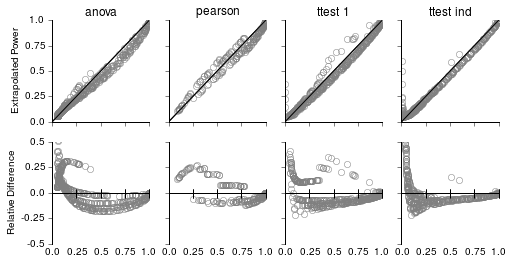

In [275]:
fig1 = plt.figure()
fig1.set_size_inches((8, 4))
xx = []
yy = []
for idx, test in enumerate(dists.index):
    x = np.concatenate(dists.loc[test, 'trad'])
    y = np.concatenate(dists.loc[test, 'exzt'])
    xx.append(x)
    yy.append(y)
    ax1 = fig1.add_subplot(2, 4, idx + 1)
    ax2 = fig1.add_subplot(2, 4, idx + 5)
    ax1.plot([0, 1], [0, 1], 'k-')
    ax2.plot([0, 1], [0, 0], 'k-')
    ax2.plot([0.25, 0.5, 0.75, 1.0], [0, 0, 0, 0], 'k|', ms=9, mew=1)
    ax1.plot(x, y, 'o', mec=[0.5, 0.5, 0.5], mfc='none')
    ax2.plot(x, (y - x) / x, 'o', mec=[0.5, 0.5, 0.5], mfc='none')
    
    ax1.plot([0, 1], [0, 1], 'k-')
    ax2.plot([0, 1], [0, 0], 'k-')
    ax2.plot([0.25, 0.5, 0.75, 1.0], [0, 0, 0, 0], 'k|', ms=9, mew=1)
    
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax2.set_xlim([0, 1])
    ax2.set_ylim([-0.5, 0.5])
    ax1.set_title(test.replace('_', ' '))
    ax1.set_xticks(np.arange(0, 1.1, 0.25))
    ax2.set_xticks(np.arange(0, 1.1, 0.25))
    ax1.set_yticks(np.arange(0, 1.1, 0.25))
    ax2.set_yticks(np.arange(-0.5, 0.6, 0.25))
#     ax2.set_yticks(np.arange(0, ))
    if idx > 0:
        ax1.set_yticklabels('')
        ax2.set_yticklabels('')
    else:
        ax1.set_yticklabels(np.arange(0, 1.1, 0.25), size=10)
        ax1.set_ylabel('Extrapolated Power')
        ax2.set_yticklabels(ax2.get_yticks(), size=10)
        ax2.set_ylabel('Relative Difference')
    ax1.set_xticklabels('')
    ax2.set_xticklabels(np.arange(0, 1.1, 0.25), size=10)
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.get_xaxis().set_tick_params(direction='out')
    ax1.get_yaxis().set_tick_params(direction='out')
    ax2.get_yaxis().set_tick_params(direction='out')
    ax2.yaxis.set_ticks_position('left')
    ax2.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax2.get_xaxis().set_tick_params(tick1On=False, tick2On=False)
    ax1.get_yaxis().set_tick_params(tick2On=False)

fig1.savefig('/Users/jwdebelius/Desktop/power_figs/normal/pseudo_infered_power1.pdf')

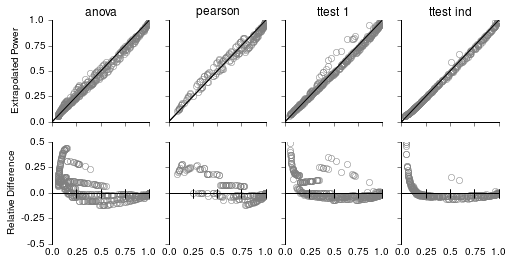

In [278]:
fig1 = plt.figure()
fig1.set_size_inches((8, 4))
xx = []
yy = []
for idx, test in enumerate(dists.index):
    x = np.concatenate(dists.loc[test, 'trad'])
    y = np.concatenate([ap.z_power(counts, (ap.z_effect(counts[(y1 > 0.15) & (y1 < 1)], 
                                                        y1[(y1 > 0.15) & (y1 < 1)])
                                           ).mean()) 
                        for y1 in dists.loc[test, 'trad']])
    xx.append(x)
    yy.append(y)
    ax1 = fig1.add_subplot(2, 4, idx + 1)
    ax2 = fig1.add_subplot(2, 4, idx + 5)
    ax1.plot([0, 1], [0, 1], 'k-')
    ax2.plot([0, 1], [0, 0], 'k-')
    ax2.plot([0.25, 0.5, 0.75, 1.0], [0, 0, 0, 0], 'k|', ms=9, mew=1)
    ax1.plot(x, y, 'o', mec=[0.5, 0.5, 0.5], mfc='none')
    ax2.plot(x, (y - x) / x, 'o', mec=[0.5, 0.5, 0.5], mfc='none')
    
    ax1.plot([0, 1], [0, 1], 'k-')
    ax2.plot([0, 1], [0, 0], 'k-')
    ax2.plot([0.25, 0.5, 0.75, 1.0], [0, 0, 0, 0], 'k|', ms=9, mew=1)
    
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax2.set_xlim([0, 1])
    ax2.set_ylim([-0.5, 0.5])
    ax1.set_title(test.replace('_', ' '))
    ax1.set_xticks(np.arange(0, 1.1, 0.25))
    ax2.set_xticks(np.arange(0, 1.1, 0.25))
    ax1.set_yticks(np.arange(0, 1.1, 0.25))
    ax2.set_yticks(np.arange(-0.5, 0.6, 0.25))
#     ax2.set_yticks(np.arange(0, ))
    if idx > 0:
        ax1.set_yticklabels('')
        ax2.set_yticklabels('')
    else:
        ax1.set_yticklabels(np.arange(0, 1.1, 0.25), size=10)
        ax1.set_ylabel('Extrapolated Power')
        ax2.set_yticklabels(np.arange(-0.5, 0.6, 0.25), size=10)
        ax2.set_ylabel('Relative Difference')
    ax1.set_xticklabels('')
    ax2.set_xticklabels(np.arange(0, 1.1, 0.25), size=10)
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.get_xaxis().set_tick_params(direction='out')
    ax1.get_yaxis().set_tick_params(direction='out')
    ax2.get_yaxis().set_tick_params(direction='out')
    ax2.yaxis.set_ticks_position('left')
    ax2.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax2.get_xaxis().set_tick_params(tick1On=False, tick2On=False)
    ax1.get_yaxis().set_tick_params(tick2On=False)

fig1.savefig('/Users/jwdebelius/Desktop/power_figs/normal/pseudo_infered_power2.pdf')

In [23]:
x = np.array(dists.loc[test, 'trad'])
y = np.array(dists.loc[test, 'exzt'])
i = np.arange(0, x.shape[0])

There is a strong ratio between test-based power, and the power calculated from that effect size. However, this is altered when tradtitional power is less than 0.05. So, let's remove values where traditional power is less than 0.05

In [24]:
x = np.concatenate(x1)
y = np.concatenate(y1)
i = (x > 0.01)
j = (x > 0.05)

In [25]:
i

array([ True,  True,  True, ..., False, False, False], dtype=bool)

In [26]:
print '%1.3f' % scipy.stats.pearsonr(y[i], x[i])[0]
print '%1.3f' % scipy.stats.pearsonr(y[j], x[j])[0]
print '%1.3f' % scipy.stats.pearsonr(y, x)[0]

0.996
0.995
0.994


In [27]:
print '%1.3f +/- %1.3f' % (np.round(np.mean(y[i] / x[i]), 3), 
                           np.round(np.std(y[i] / x[i]) /
                                    np.sqrt(i.sum()) * scipy.stats.t.ppf(0.975, np.sum(i)), 3))
print '%1.3f +/- %1.3f' % (np.round(np.mean(y[j] / x[j]), 3), 
                           np.round(np.std(y[j] / x[j]) /
                                    np.sqrt(j.sum()) * scipy.stats.t.ppf(0.975, np.sum(j)), 3))
print '%1.3f +/- %1.3f' % (np.round(np.mean(y / x), 3), 
                           np.round(np.std(y / x) /
                                    np.sqrt(len(x)) * scipy.stats.t.ppf(0.975, len(x)), 3))

1.090 +/- 0.009
0.997 +/- 0.002
2.628 +/- 0.577


Based on the graphs, it looks like the bias is largely associated with values for low power.

I'd also like to 

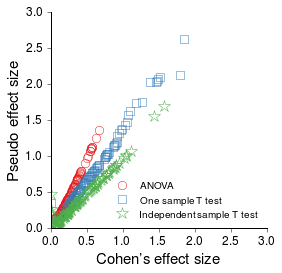

In [276]:
ax = plt.axes()
for idx, (test, color, marker, ms, label) in enumerate([('anova', '#e41a1c', 'o', 8, 'ANOVA'), 
                                                        ('ttest_1', '#377eb8', 's', 8, 'One sample T test'), 
                                                        ('ttest_ind', '#4daf4a', '*', 12, 'Independent sample T test')]):
    effs = np.array(dists.loc[test, 'effs'])
    x = effs[:, 0]
    y = effs[:, 2]
    n = effs.shape[1]
    ax.plot(x, y, marker, mfc='none', mec=color, ms=ms, label=label)

ax.set_xlim([0, 3])
ax.set_xticklabels(np.arange(0, 3.1, 0.5), size=12)
ax.set_yticklabels(np.arange(0, 3.1, 0.5), size=12)
ax.set_xlabel("Cohen's effect size", size=15)
ax.set_ylabel("Pseudo effect size", size=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_tick_params(direction='out')
ax.get_yaxis().set_tick_params(direction='out')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.legend(loc=4, frameon=False, numpoints=1, fontsize=10)

fig = ax.get_figure()
fig.set_size_inches((4, 4))
ax.set_position((0.125, 0.125, 0.75, 0.75))
fig.savefig('/Users/jwdebelius/Desktop/power_figs/normal/norm_effect_size.pdf')

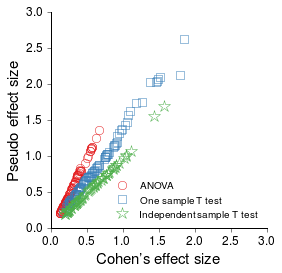

In [279]:
ax = plt.axes()
for idx, (test, color, marker, ms, label) in enumerate([('anova', '#e41a1c', 'o', 8, 'ANOVA'), 
                                                        ('ttest_1', '#377eb8', 's', 8, 'One sample T test'), 
                                                        ('ttest_ind', '#4daf4a', '*', 12, 'Independent sample T test')]):
    effs = np.array(dists.loc[test, 'effs'])
    x = effs[:, 0]
    y = np.array([
            (ap.z_effect(counts[(y1 > 0.15) & (y1 < 1)], y1[(y1 > 0.15) & (y1 < 1)])).mean() 
            for y1 in dists.loc[test, 'trad']])
    n = effs.shape[1]
    ax.plot(x, y, marker, mfc='none', mec=color, ms=ms, label=label)

ax.set_xlim([0, 3])
ax.set_xticklabels(np.arange(0, 3.1, 0.5), size=12)
ax.set_yticklabels(np.arange(0, 3.1, 0.5), size=12)
ax.set_xlabel("Cohen's effect size", size=15)
ax.set_ylabel("Pseudo effect size", size=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_tick_params(direction='out')
ax.get_yaxis().set_tick_params(direction='out')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.legend(loc=4, frameon=False, numpoints=1, fontsize=10)

fig = ax.get_figure()
fig.set_size_inches((4, 4))
ax.set_position((0.125, 0.125, 0.75, 0.75))
fig.savefig('/Users/jwdebelius/Desktop/power_figs/normal/norm_effect_size2.pdf')

In [124]:
xi = []
xj = []
yi = []
yj = []
for idx, (test, color, mod) in enumerate([('anova', 'r', 2), ('ttest_1', 'g', np.sqrt(2)), ('ttest_ind', 'b', 1)]):
    effs = np.array(dists.loc[test, 'effs'])
    x = effs[:, 0]
    y = effs[:, 2]
    n = effs.shape[1]
    i = (0.1 < x) * (x < 1.5)
    r1 = scipy.stats.pearsonr(x, y)[0]
    r2 = scipy.stats.pearsonr(x[i], y[i])[0]
    rat1 = x / y
    rat2 = x[i] / y[i]
    xi.append(x)
    yi.append(y / mod)
    xj.append(x[i])
    yj.append(y[i] / mod)
    
    print '%s   \t %1.3f \t %1.3f +/- %1.3f\t %1.3f \t %1.3f +/- %1.3f' % (
        test,
        r1, rat1.mean(), rat1.std() / np.sqrt(n) * scipy.stats.t.ppf(0.975, n-1),
        r2, rat2.mean(), rat2.std() / np.sqrt(i.sum()) * scipy.stats.t.ppf(0.975, i.sum() - 1)
    )
    print '%s   \t %1.3f \t %1.3f +/- %1.3f\t %1.3f \t %1.3f +/- %1.3f' % (
        test,
        r1, (rat1 * mod).mean(), (rat1 * mod).std() / np.sqrt(n) * scipy.stats.t.ppf(0.975, n-1),
        r2, (rat2 * mod).mean(), (rat2 * mod).std() / np.sqrt(i.sum()) * scipy.stats.t.ppf(0.975, i.sum() - 1)
    )

anova   	 0.996 	 0.563 +/- 0.135	 0.999 	 0.573 +/- 0.007
anova   	 0.996 	 1.126 +/- 0.270	 0.999 	 1.146 +/- 0.015
ttest_1   	 0.993 	 0.760 +/- 0.213	 0.998 	 0.767 +/- 0.008
ttest_1   	 0.993 	 1.075 +/- 0.302	 0.998 	 1.084 +/- 0.011
ttest_ind   	 0.979 	 1.044 +/- 0.649	 0.998 	 1.110 +/- 0.023
ttest_ind   	 0.979 	 1.044 +/- 0.649	 0.998 	 1.110 +/- 0.023


In [125]:
1.147 - 0.005, 1.147 + 0.005

(1.1420000000000001, 1.152)

In [126]:
print np.round(scipy.stats.pearsonr(np.concatenate(xi), np.concatenate(yi))[0], 4)
print np.round(scipy.stats.pearsonr(np.concatenate(xj), np.concatenate(yj))[0], 4)

0.9894
0.9982


In [127]:
np.mean(np.concatenate(xi) / np.concatenate(yi))

1.0815672583574942

In [128]:
np.std(np.concatenate(xi) / np.concatenate(yi)) / np.sqrt(n) * scipy.stats.t.ppf(0.975, n-1)

0.44976790209801132

In [129]:
np.round((1.0783 - 0.470, 1.0783 + 0.470), 1)

array([ 0.6,  1.5])

In [130]:
np.mean(np.concatenate(xj) / np.concatenate(yj))

1.1133216020321015

In [131]:
n = len(np.concatenate(xj))
np.std(np.concatenate(xj) / np.concatenate(yj)) / np.sqrt(n) * scipy.stats.t.ppf(0.975, n-1)

0.0099425316307579885

In [132]:
xi = np.concatenate(xi)
yi = np.concatenate(yi)

In [133]:
rxyi = xi / yi
rxyi = np.mean(rxyi[np.isinf(rxyi) == False])
rxzi = xi / zi
rzyi = np.mean(rzyi[np.isinf(rzyi) == False])
ryzi = yi / zi
ryzi = np.mean(ryzi[np.isinf(ryzi) == False])

NameError: name 'zi' is not defined

In [ ]:
mods = {'ANOVA', 2}

In [ ]:
np.infmean([1, 2, np.inf])

### 7.0.1 Emprical Power

In [60]:
xall = []
yall = []
zall = []
for idx, name in enumerate(dists.index.values):
    x = np.concatenate(dists.loc[name, 'trad'])
    y = np.concatenate(dists.loc[name, 'empr'])
    z = np.concatenate(dists.loc[name, 'extz'])
    xall.append(x)
    yall.append(y)
    zall.append(z)
    i = x > 0.05
    n = len(x)
    xi = x[i]
    yi = y[i]
    zi = z[i]
    ni = len(xi)
    
    rxy = x / y
    rxy = rxy[np.isinf(rxy) == False]
    rxz = x / z
    ryz = rxz[np.isinf(rxz) == False]
    ryz = y / z
    ryz = ryz[np.isinf(ryz) == False]
    
    rxyi = xi / yi
    rxyi = rxyi[np.isinf(rxyi) == False]
    rxzi = xi / zi
    rxzi = rxzi[np.isinf(rxzi) == False]
    ryzi = yi / zi
    ryzi = ryzi[np.isinf(ryzi) == False]
    
    print name
    print 'trad/empr, raw  ', np.round(
        (scipy.stats.pearsonr(x, y)[0], np.mean(rxy), np.std(rxy) / np.sqrt(len(rxy)) * 1.96), 3
        )
    print 'trad/empr, round', np.round(
        (scipy.stats.pearsonr(xi, yi)[0], np.mean(rxyi), np.std(rxyi) / np.sqrt(len(rxyi)) * 1.96), 3
        )
    print ''
    print 'trad/extr, raw  ', np.round(
        (scipy.stats.pearsonr(x, z)[0], np.mean(rxz), np.std(rxz) / np.sqrt(len(rxz)) * 1.96), 3
        )
    print 'trad/extr, round', np.round(
        (scipy.stats.pearsonr(xi, zi)[0], np.mean(rxzi), np.std(rxzi) / np.sqrt(len(rxzi)) * 1.96), 3
        )
    print ''


anova
trad/empr, raw   [ 0.988  1.284  0.047]
trad/empr, round [ 0.988  1.284  0.047]

trad/extr, raw   [ 0.991  0.977  0.006]
trad/extr, round [ 0.991  0.977  0.006]

pearson
trad/empr, raw   [ 0.985  1.05   0.004]
trad/empr, round [ 0.985  1.05   0.004]

trad/extr, raw   [ 0.961  1.069  0.004]
trad/extr, round [ 0.961  1.069  0.004]

ttest_1
trad/empr, raw   [ 0.995  1.086  0.017]
trad/empr, round [ 0.995  1.084  0.016]

trad/extr, raw   [ 0.994  1.037  0.005]
trad/extr, round [ 0.994  1.055  0.005]

ttest_ind
trad/empr, raw   [ 0.99   1.411  0.048]
trad/empr, round [ 0.991  1.455  0.052]

trad/extr, raw   [ 0.991  0.95   0.011]
trad/extr, round [ 0.993  1.12   0.007]



In [195]:
def format_figure(ax1, ax2, title):
    ax2.plot([0.25, 0.5, 0.75, 1.0], [0, 0, 0, 0], 'k|', ms=9, mew=1)
    ax1.plot(x, y, 'o', mec=[0.5, 0.5, 0.5], mfc='none')
    ax2.plot(x, (y - x) / x, 'o', mec=[0.5, 0.5, 0.5], mfc='none')
    
    ax1.plot([0, 1], [0, 1], 'k-')
    ax2.plot([0, 1], [0, 0], 'k-')
    ax2.plot([0.25, 0.5, 0.75, 1.0], [0, 0, 0, 0], 'k|', ms=9, mew=1)
    
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax2.set_xlim([0, 1])
    ax2.set_ylim([-2.5, 2.5])
    ax1.set_title(title.replace('_', ' '))
    ax1.set_xticks(np.arange(0, 1.1, 0.25))
    ax2.set_xticks(np.arange(0, 1.1, 0.25))
    ax1.set_yticks(np.arange(0, 1.1, 0.25))
#     ax2.set_yticks(np.arange(0, ))
    if idx > 0:
        ax1.set_yticklabels('')
        ax2.set_yticklabels('')
    else:
        ax1.set_yticklabels(np.arange(0, 1.1, 0.25), size=10)
        ax1.set_ylabel('Extrapolated Power')
        ax2.set_yticklabels(np.arange(-3., 3., 1), size=10)
        ax2.set_ylabel('Relative Difference')
    ax1.set_xticklabels('')
    ax2.set_xticklabels(np.arange(0, 1.1, 0.25), size=10)
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.get_xaxis().set_tick_params(direction='out')
    ax1.get_yaxis().set_tick_params(direction='out')
    ax2.get_yaxis().set_tick_params(direction='out')
    ax2.yaxis.set_ticks_position('left')
    ax2.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax2.get_xaxis().set_tick_params(tick1On=False, tick2On=False)
    ax1.get_yaxis().set_tick_params(tick2On=False)

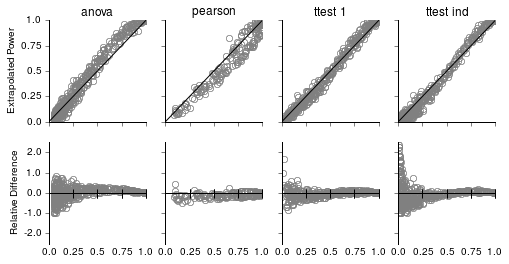

In [197]:
fig1 = plt.figure()
fig2 = plt.figure()
fig3 = plt.figure()
fig1.set_size_inches((8, 4))
fig2.set_size_inches((8, 4))
fig3.set_size_inches((8, 4))

for idx, name in enumerate(dists.index.values):
    x = np.concatenate(dists.loc[name, 'trad'])
    y = np.concatenate(dists.loc[name, 'empr'])
    
    ax1 = fig1.add_subplot(2, 4, idx+1)
    ax2 = fig1.add_subplot(2, 4, idx+5)
    
    ax1.plot(x, y, 'o', mec=[0.5, 0.5, 0.5], mfc='none')
    ax2.plot(x, (y-x)/x, 'o', mec=[0.5, 0.5, 0.5], mfc='none')
        
    format_figure(ax1, ax2, name.replace('_', ' '))
    
    fig1.savefig('/Users/jwdebelius/Desktop/power_figs/normal/test_v_emprical.pdf')

In [168]:
rxya = np.concatenate(xall) / np.concatenate(yall)
rxya = rxya[np.isinf(rxya) == False]
rxza = np.concatenate(xall) / np.concatenate(zall)
rxza = rxza[np.isinf(rxza) == False]

print np.round(
    (scipy.stats.pearsonr(np.concatenate(xall), np.concatenate(yall))[0],
     np.mean(rxya),
     np.std(rxya) / np.sqrt(len(rxya)) * 1.96
     ), 3)
print np.round(
    (scipy.stats.pearsonr(np.concatenate(xall), np.concatenate(zall))[0],
     np.mean(rxza),
     np.std(rxza) / np.sqrt(len(rxza)) * 1.96
     ), 3)

[ 0.978  1.143  0.033]
[ 0.989  1.082  0.02 ]


In [169]:
print np.isinf(x).any()
print np.isinf(y).any()
print np.isinf(x / y).any()

False
False
False


In [170]:
print scipy.stats.pearsonr(x, y)
print np.mean(x / y)
print np.std(x / y)

(0.98864408487922795, 1.7589751986278229e-82)
1.11437102273
0.367931583052


In [190]:
def format_eff_ax(ax):
    ax.set_xlim([0, 2])
    ax.set_xticklabels(np.arange(0, 3.1, 0.5), size=12)
    ax.set_yticklabels(np.arange(0, 3.1, 0.5), size=12)
    ax.set_xlabel("Cohen's effect size", size=15)
    ax.set_ylabel("Pseudo effect size", size=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().set_tick_params(direction='out')
    ax.get_yaxis().set_tick_params(direction='out')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.legend(loc=4, frameon=False, numpoints=1, fontsize=10)



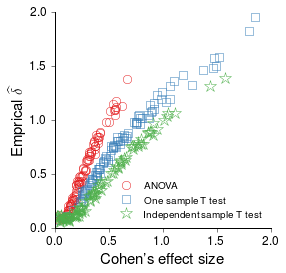

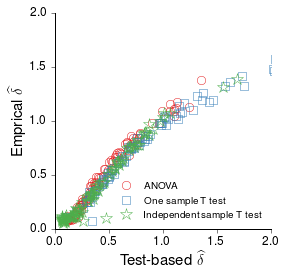

In [194]:
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_axes((0.125, 0.125, 0.75, 0.75))
ax2 = fig2.add_axes((0.125, 0.125, 0.75, 0.75))
for idx, (test, color, marker, ms, label) in enumerate([('anova', '#e41a1c', 'o', 8, 'ANOVA'), 
                                                        ('ttest_1', '#377eb8', 's', 8, 'One sample T test'), 
                                                        ('ttest_ind', '#4daf4a', '*', 12, 'Independent sample T test')]):
    effs = np.array(dists.loc[test, 'effs'])
    x = effs[:, 0]
    y = effs[:, 1]
    z = effs[:, 2]
    n = effs.shape[1]
    ax1.plot(x, y, marker, mfc='none', mec=color, ms=ms, label=label)
    ax2.plot(z, y, marker, mfc='none', mec=color, ms=ms, label=label)

    format_eff_ax(ax1)
    format_eff_ax(ax2)
    
    ax1.set_ylabel('Emprical $\widehat{\delta}$')
    ax2.set_ylabel('Emprical $\widehat{\delta}$')
    ax2.set_xlabel('Test-based $\widehat{\delta}$')
    
    fig1.set_size_inches((4, 4))
    fig2.set_size_inches((4, 4))
    
    fig1.savefig('/Users/jwdebelius/Desktop/power_figs/normal/test_v_emprical_eff.pdf')
    fig2.savefig('/Users/jwdebelius/Desktop/power_figs/normal/trad_v_emprical_eff.pdf')

In [171]:
xall = []
yall = []
zall = []
for idx, (test, color, mod) in enumerate([('anova', 'r', 2), ('ttest_1', 'g', np.sqrt(2)), ('ttest_ind', 'b', 1)]):
    eff = np.array(dists.loc[test, 'effs'])
    x = eff[:, 0]
    y = eff[:, 1] / mod
    z = eff[:, 2] / mod
    i = (x > 0.1) * (x < 1.5)
    xi = x[i]
    yi = y[i]
    zi = z[i]
    
    xall.append(x)
    yall.append(y)
    zall.append(z)
    
    print test
    print np.round(
        (scipy.stats.pearsonr(x, y)[0],
         np.mean(x / y),
         np.std(x / y) / np.sqrt(len(x)) * 1.96
        ), 3)
    print np.round(
        (scipy.stats.pearsonr(xi, yi)[0],
         np.mean(xi / yi),
         np.std(xi / yi) / np.sqrt(len(xi)) * 1.96
        ), 3)
    print ''
    print np.round(
        (scipy.stats.pearsonr(x, y)[0],
         np.mean(z / y),
         np.std(z / y) / np.sqrt(len(x)) * 1.96
        ), 3)
    print np.round(
        (scipy.stats.pearsonr(xi, yi)[0],
         np.mean(zi / yi),
         np.std(zi / yi) / np.sqrt(len(xi)) * 1.96
        ), 3)

anova
[ 0.989  1.176  0.06 ]
[ 0.988  1.158  0.058]

[ 0.989  1.046  0.05 ]
[ 0.988  1.006  0.043]
ttest_1
[ 0.982  1.139  0.032]
[ 0.98   1.142  0.024]

[ 0.982  1.099  0.079]
[ 0.98   1.055  0.023]
ttest_ind
[ 0.989  1.114  0.072]
[ 0.994  1.214  0.06 ]

[ 0.989  1.138  0.094]
[ 0.994  1.088  0.042]


In [172]:
xall = np.concatenate(xall)
yall = np.concatenate(yall)
zall = np.concatenate(zall)
iall = (xall > 0.1) * (xall < 1.5)
print scipy.stats.pearsonr(xall, yall)[0]

0.978074182166


In [173]:
print np.isinf(xall).any()
print np.isinf(yall).any()
print np.isinf(xall / yall).any()

False
False
False


In [174]:
np.round((np.mean((xall / yall)[np.isinf(xall / yall) == False]), np.std((xall / yall)[np.isinf(xall / yall) == False]) / np.sqrt(np.sum(np.isinf(xall / yall) == False)) * 1.96), 3)

array([ 1.143,  0.033])

In [175]:
print scipy.stats.pearsonr(xall[iall], yall[iall])[0]
print np.round((np.mean(xall[iall] / yall[iall]), np.std(xall[iall] / yall[iall]) / np.sqrt(len(xall[iall])) * 1.96), 3)

0.978035345138
[ 1.17   0.029]


In [176]:
print scipy.stats.pearsonr(zall, yall)[0]
print np.round((np.mean(zall / yall), np.std(zall / yall) / np.sqrt(len(zall)) * 1.96), 3)

0.972591722986
[ 1.094  0.044]


In [177]:
print scipy.stats.pearsonr(zall[iall], yall[iall])[0]
print np.round((np.mean(zall[iall] / yall[iall]), np.std(zall[iall] / yall[iall]) / np.sqrt(len(zall[iall])) * 1.96), 3)

0.974833750431
[ 1.048  0.022]


#References

1. <a id="lui2014"></a>Lui, X.S. (2014) *[Statistical power analysis for the social and behavioral sciences: basic and advanced techniques](http://roger.ucsd.edu/search~S9?/Xstatistical%20power&=&Da=&Db=&searchscope=9&p=&SORT=D/Xstatistical%20power&=&Da=&Db=&searchscope=9&p=&SORT=D&SUBKEY=statistical+power/1%2C861%2C861%2CE/frameset&FF=Xstatistical%20power&=&Da=&Db=&searchscope=9&p=&SORT=D&1%2C1%2C)*. New York: Routledge. 378 pg.
2. <a id="zar1999"></a>Zar, J.H. (1999) "Multisample Hypothesis: The Analysis of Variance". Ch. 10. *Biostatistical Analysis*. 4th Ed. Upper Saddle River: Prentice Hall.
3. <a id="cohen"></a>Cohen, J. (1991) "[A Power Primer](https://thehubedu-production.s3.amazonaws.com/uploads/2522/a39eb8b3-385c-4db8-a4b4-0f5afe0c0af3/Cohen_1992_sample_size.pdf)" *Psychology Bulletin*. **112**: 155-159. 